## Code for reading the HAR-UML dataset

In [9]:
%load_ext autoreload
%autoreload 2

import numpy as np
from source.read_HAR_dataset import read_har_dataset, har_dimensions, har_activities_map
from source.utils import create_dir
import os

# Shuffle all data from all participants (SHOULD BE ONLY USED TO FIND THE BEST MODEL)
SHUFFLE_ALL = False
LOSS = "SupConLoss" # "Contrastive" or "Triplet"  or "SupConLoss" or "SimCLR"
SUBSEC_PORC = 0.9 # Porcentage of the window to be used as a sub-sequence
FEAT_DIM = 16 # Dimension of the code of input to the LOSS criterion (IS NOT THE FEATERURE DIMENSION!!)
EPOCHS   = 8 # You know ...
EXP_DIR = 'experiments'

mode = 'shuffle' if SHUFFLE_ALL else 'noshuffle'

EXPERIMENT_NAME = 'Exp_{}_{}_{}_{}'.format(LOSS, mode, FEAT_DIM, int(SUBSEC_PORC * 100), EPOCHS)
EXP_PATH = os.path.join(EXP_DIR, EXPERIMENT_NAME)
create_dir(EXP_DIR)
create_dir(EXP_PATH)

activities = [
    "Sitting",
    "Lying",
    "Standing",
    "Walking",
    "Running",
    "Downstairs",
    "Upstairs"
]

har_activities = activities

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:

data = read_har_dataset('./datasets/HAR-UML20/')

ids_train, X_train, y_train, I_train, train_kcal_MET = data['train']

ids_val, X_val, y_val, I_val, val_kcal_MET = data['val']

ids_test, X_test, y_test, I_test, test_kcal_MET = data['test']

Train IDS: [8, 7, 1, 6, 4, 0]
Test IDS: [5, 2]
Val IDS: [9, 3]
IDS: [8, 7, 1, 6, 4, 0, 5, 2, 9, 3]


In [11]:
y_train[y_train==0] = 0
y_train[y_train==1] = 0
y_train[y_train==2] = 0
y_val[y_val==0] = 0
y_val[y_val==1] = 0
y_val[y_val==2] = 0
y_test[y_test==0] = 0
y_test[y_test==1] = 0
y_test[y_test==2] = 0

for i in range(3, len(har_activities)):
    y_train[y_train==i] = i - 2
    y_test[y_test==i] = i - 2
    y_val[y_val==i] = i - 2

In [12]:
def shuffle_data(train_list, test_list, val_list, shuffled_indices):
    X = np.concatenate([train_list, test_list, val_list], axis=0)
    X = np.array([X[i] for i in shuffled_indices])
    n_tr = len(train_list)
    n_te = len(test_list)
    n_val = len(val_list)
    return X[0: n_tr], X[n_tr: n_tr + n_te], X[n_tr + n_te:]

if SHUFFLE_ALL:
    n = X_train.shape[0] + X_val.shape[0] + X_test.shape[0]
    ids = list(range(n))
    shuffled_indices = np.random.permutation(len(ids))

    X_train, X_test, X_val = shuffle_data(X_train, X_test, X_val, shuffled_indices)
    y_train, y_test, y_val = shuffle_data(y_train, y_test, y_val, shuffled_indices)
    I_train, I_test, I_val = shuffle_data(I_train, I_test, I_val, shuffled_indices)
    train_kcal_MET, test_kcal_MET, val_kcal_MET = shuffle_data(train_kcal_MET, test_kcal_MET, val_kcal_MET, shuffled_indices)

In [13]:
har_dimensions

array(['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z',
       'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z', 'Magnetometer-X',
       'Magnetometer-Y', 'Magnetometer-Z'], dtype='<U15')

In [14]:
from source.tserie import TSerie
from source.utils import  filter_dimensions
dimensions = ['Accelerometer-X', 'Accelerometer-Y', 'Accelerometer-Z', 'Gyrometer-X', 'Gyrometer-Y', 'Gyrometer-Z']

X_train_f = filter_dimensions(X_train, har_dimensions, dimensions)
X_test_f = filter_dimensions(X_test, har_dimensions, dimensions)
X_val_f = filter_dimensions(X_val, har_dimensions, dimensions)

mts_train = TSerie(X = X_train_f, y = y_train, I = I_train, dimensions = dimensions, classLabels=har_activities_map)
mts_test = TSerie(X = X_test_f, y = y_test, I = I_test, dimensions = dimensions, classLabels=har_activities_map)
mts_val = TSerie(X = X_val_f, y = y_val, I = I_val, dimensions = dimensions, classLabels=har_activities_map)


minl, maxl = mts_train.minMaxNormalization()
mts_val.minMaxNormalization(minl=minl, maxl=maxl)
mts_test.minMaxNormalization(minl=minl, maxl=maxl)
# mts_train.center()
# mts_val.center()
# mts_test.center()

mts_train.znorm()
mts_val.znorm()
mts_test.znorm()

minl, maxl = mts_train.minMaxNormalization()
mts_val.minMaxNormalization(minl=minl, maxl=maxl)
mts_test.minMaxNormalization(minl=minl, maxl=maxl)

([-1.2347009181976318,
  -1.5885978937149048,
  -1.0381275415420532,
  -4.732575416564941,
  -3.347278356552124,
  -3.3371174335479736],
 [1.542318344116211,
  0.7820973992347717,
  0.7367585301399231,
  2.8887481689453125,
  2.6872572898864746,
  3.323666572570801])

In [15]:
from source.datasets import ContrastiveDataset
from torch.utils.data import DataLoader

train_dataset = ContrastiveDataset(mts_train.X.transpose([0, 2, 1]).astype(np.float32), y_train, use_label=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = ContrastiveDataset(mts_val.X.transpose([0, 2, 1]).astype(np.float32), y_val, use_label=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_dataset = ContrastiveDataset(mts_test.X.transpose([0, 2, 1]).astype(np.float32), y_test, use_label=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Subsequence length: 180
Epoch[1] Train loss    avg: 5.715639195864713
Epoch[1] Val loss      avg: 4.094325227557488
[Log] Saving model with loss: 4.094325227557488
Epoch[2] Train loss    avg: 4.125626253176339
Epoch[2] Val loss      avg: 4.080663136716159
[Log] Saving model with loss: 4.080663136716159
Epoch[3] Train loss    avg: 4.115619979327238
Epoch[3] Val loss      avg: 4.065685191244449
[Log] Saving model with loss: 4.065685191244449
Epoch[4] Train loss    avg: 4.09545031227643
Epoch[4] Val loss      avg: 4.0510706316750005
[Log] Saving model with loss: 4.0510706316750005
Epoch[5] Train loss    avg: 4.092213835897325
Epoch[5] Val loss      avg: 4.041917252090742
[Log] Saving model with loss: 4.041917252090742
Epoch[6] Train loss    avg: 4.08202873755105
Epoch[6] Val loss      avg: 4.066846964494237
Epoch[7] Train loss    avg: 4.073728849616232
Epoch[7] Val loss      avg: 4.069549879937802
Epoch[8] Train loss    avg: 4.076969293099415
Epoch[8] Val loss      avg: 4.05448661210402


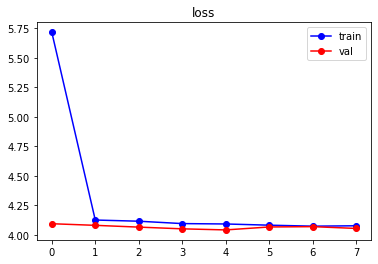

In [16]:
%autoreload 2
from torch_snippets import *
from source.models.contrastive.models import LSTMSiameseNetwork, SiameseNetwork, train_batch, train_batch_contrastive, train_batch_triplet, eval_batch, eval_batch_contrastive, eval_batch_triplet
from source.losses import ContrastiveLoss, SupConLoss, TripletLoss
from source.utils import ValueLogger
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'



subsequence_length = int(X_train_f.shape[1] * SUBSEC_PORC)

print("Subsequence length: {}".format(subsequence_length))

model      = LSTMSiameseNetwork(X_train_f.shape[2], subsequence_length, device, feat_size=1024, encoding_size=8, head='mlp', conv_filters=[16, 16, 16], conv_kernels=[5, 5, 5]).to(device)

model_path = os.path.join(EXP_PATH, 'model.pt')
loss_path = os.path.join(EXP_PATH, 'loss.png')

if LOSS == "Contrastive":
    criterion  = ContrastiveLoss().to(device)
elif LOSS == "Triplet":
    criterion  = TripletLoss(margin=4.0).to(device)
elif LOSS == "SupConLoss":
    criterion = SupConLoss().to(device)
    supervised = True
else:
    criterion = SupConLoss().to(device)
    supervised = False

trainLogs = ValueLogger("Train loss   ", epoch_freq=1)
testLogs = ValueLogger( "Test loss    ", epoch_freq=1)
valLogs = ValueLogger(  "Val loss     ", epoch_freq=1)

optimizer  = optim.AdamW(model.parameters(),lr = 0.0005)
# optimizer  = optim.AdamW(model.parameters(),lr = 0.00001) #Triplet
# optimizer  = optim.SGD(model.parameters(),lr = 0.001)
# optimizer  = optim.Adam(model.parameters(),lr = 0.0001, weight_decay=0.004)

for epoch in range(EPOCHS):
    N = len(train_dataloader)
    for i, data in enumerate(train_dataloader):
        loss = None
        if LOSS == "Contrastive":
            loss = train_batch_contrastive(model, data, optimizer, criterion, device, subsequence_length)
        elif LOSS == "Triplet":
            loss = train_batch_triplet(model, data, optimizer, criterion, device, subsequence_length)
        elif LOSS == "SupConLoss":
            loss = train_batch(model, data, optimizer, criterion, device, subsequence_length, supervised=supervised)
        else:
            loss = train_batch(model, data, optimizer, criterion, device, subsequence_length, supervised=supervised)
        trainLogs.update(loss)
    trainLogs.end_epoch()
    with torch.no_grad():
        N = len(val_dataloader)
        for i, data in enumerate(val_dataloader):
            if LOSS == "Contrastive":
                loss = eval_batch_contrastive(model, data,  criterion, device, subsequence_length)
            elif LOSS == "Triplet":
                loss = eval_batch_triplet(model, data,  criterion, device, subsequence_length)
            elif LOSS == "SupConLoss":
                loss = eval_batch(model, data,  criterion, device, subsequence_length, supervised=supervised)
            else:
                loss = eval_batch(model, data,  criterion, device, subsequence_length, supervised=supervised)
            valLogs.update(loss)
                
        if  valLogs.end_epoch():
            print('[Log] Saving model with loss: {}'.format(valLogs.bestAvg))
            torch.save(model, model_path) 

fig = plt.figure()
ax0 = fig.add_subplot(111, title="loss")
ax0.plot(trainLogs.avgs, 'bo-', label='train')
ax0.plot(valLogs.avgs, 'ro-', label='val')

ax0.legend()
fig.savefig(loss_path)

In [17]:
  
model = torch.load(model_path)
with torch.no_grad():
    N = len(test_dataloader)
    for i, data in enumerate(test_dataloader):
        if LOSS == "Contrastive":
            if LOSS == "Contrastive":
                loss = eval_batch_contrastive(model, data, criterion, device, subsequence_length)
            elif LOSS == "Triplet":
                loss = eval_batch_triplet(model, data, criterion, device, subsequence_length)
            elif LOSS == "SupConLoss":
                loss = eval_batch(model, data, criterion, device, subsequence_length, supervised=supervised)
            else:
                loss = eval_batch(model, data, criterion, device, subsequence_length, supervised=supervised)
        testLogs.update(loss)
    testLogs.end_epoch()

Epoch[1] Test loss     avg: 3.281736373901367


In [18]:
# # ---------------Load best model is you already saved it-----------------
# model      = SiameseNetwork(X_train_f.shape[2], win_len).to(device)
# model = torch.load(model_path)

In [19]:
# Get the representations from the model
train_repr = model.encode(X_train_f.transpose(0, 2, 1), device)
test_repr = model.encode(X_test_f.transpose(0, 2, 1), device)

## VISUALIZATION TASK

In [20]:
import umap
reducer = umap.UMAP(n_components = 2)
reducer.fit(train_repr, y=y_train)
# reducer.fit(train_repr)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


UMAP(tqdm_kwds={'bar_format': '{desc}: {percentage:3.0f}%| {bar} {n_fmt}/{total_fmt} [{elapsed}]', 'desc': 'Epochs completed', 'disable': True})

In [21]:
train_coords = reducer.transform(train_repr)
test_coords = reducer.transform(test_repr)

['Sitting', 'Lying', 'Standing', 'Walking', 'Running', 'Downstairs', 'Upstairs']


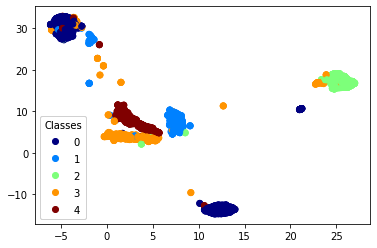

In [22]:
import matplotlib.pyplot as plt

print(activities)
fig, ax = plt.subplots()

scatter = ax.scatter(train_coords[:, 0], train_coords[:, 1], c = y_train, cmap='jet', label='Inline label')

legend1 = ax.legend(*scatter.legend_elements(),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)



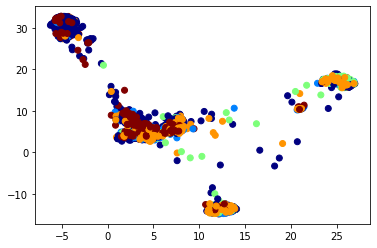

In [23]:
plt.scatter(test_coords[:, 0], test_coords[:, 1], c = y_test, cmap='jet')

## CLASSIFICATION TASK

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn import svm

def classify_dataset(X_train, y_train, X_test, y_test):
    # clf = RandomForestClassifier(random_state=0)
    # clf = LinearSVC(dual=False, random_state=123)
    # clf = svm.SVC()
    clf = KNeighborsClassifier()
    clf.fit(X_train, y_train)
    return clf.predict(X_train), clf.predict(X_test)
    

train_pred, test_pred = classify_dataset(train_repr, y_train, test_repr, y_test)



/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:207: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [25]:
from sklearn import metrics

bal_acc_tr = metrics.balanced_accuracy_score(y_train, train_pred)
bal_acc_te = metrics.balanced_accuracy_score(y_test, test_pred)

acc_tr = metrics.accuracy_score(y_train, train_pred)
acc_te = metrics.accuracy_score(y_test, test_pred)
            
f1_tr = metrics.f1_score(y_train, train_pred, average='weighted')
f1_te = metrics.f1_score(y_test, test_pred, average='weighted')

print("Training balanced accuracy: {} - testing balanced accuracy: {}".format(bal_acc_tr, bal_acc_te))
print("Training accuracy: {} - testing accuracy: {}".format(acc_tr, acc_te))
print("Training f1 score: {} - testing f1 score: {}".format(f1_tr, f1_te))

Training balanced accuracy: 0.6394444444444444 - testing balanced accuracy: 0.2775
Training accuracy: 0.734920634920635 - testing accuracy: 0.3470238095238095
Training f1 score: 0.7141299603167369 - testing f1 score: 0.35471212602637936


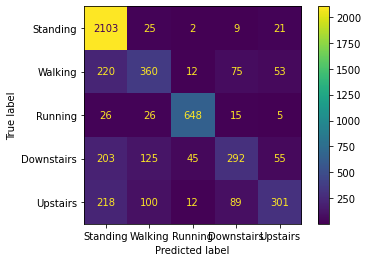

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_train, train_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels= activities[2:])
disp.plot()


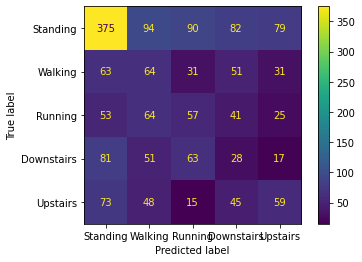

In [27]:
cm_test = confusion_matrix(y_test, test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels= activities[2:])
disp.plot()


## PREDICTION

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor

def regression_results(y_true, y_pred):
    
    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    # mse=metrics.mean_squared_error(y_true, y_pred) 
    # mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    # median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    
    
    # return round(mean_absolute_error,4), round(explained_variance,4)
    return round(mean_absolute_error,4), round(r2,4)

# regressor = LinearRegression()
regressor = SGDRegressor(loss="squared_error", penalty="l2", max_iter=20)
regressor.fit(train_repr, train_kcal_MET[:, 1])

/home/texs/anaconda3/envs/contrastive/lib/python3.10/site-packages/sklearn/linear_model/_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


SGDRegressor(max_iter=20)

In [29]:
train_met_pred = regressor.predict(train_repr) 
test_met_pred = regressor.predict(test_repr) 
# regressor.score(train_repr, train_kcal_MET[:, 1])

In [30]:
print(regression_results(train_kcal_MET[:, 1], train_met_pred))
print(regression_results(test_kcal_MET[:, 1], test_met_pred))

(1.4465, 0.4773)
(1.9396, -0.0286)


In [31]:
test_met_pred[:10]

array([3.611, 1.412, 1.839, 1.813, 1.359, 2.782, 1.934, 4.148, 2.092,
       1.716])

In [32]:
test_kcal_MET[:10, 1]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32)